In [40]:
import tensorflow
from tensorflow import keras

In [45]:
import numpy
import os 
import cv2
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_applications.mobilenet import MobileNet
from keras_applications.mobilenet import preprocess_input
from keras import backend as K
import random
import pickle
from pathlib import Path
import os

In [42]:

root = os.getcwd() # Don't change this
data_dirname = '/src/data_test/' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"


In [43]:
classes = ['Apple___Apple_scab','Apple___healthy']
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

Apple___Apple_scab
Apple___healthy


In [49]:

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = load_img(img_path, target_size=(120, 120))
img_data = img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)

File path: /Users/jonaspedersen/Dokumenter/Visual_rec/project/src/data_test/Apple___Apple_scab/bceb695a-e877-4b2b-bf05-241661d511d4___FREC_Scab 3240.JPG


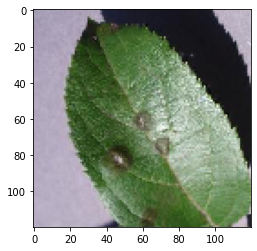

In [52]:
plt.imshow(img)